# Training and testiong a ANN for the Titanic dataset

## Importing required libraries

In [278]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from scipy import stats

from sklearn.model_selection import train_test_split

## Defining constants

In [279]:
#Collumns that are not participate in the learning

class TicketFeatures:
    TICKET = 'Ticket'
    TICKET_PARSED = 'TicketParsed'
    TICKET_NUMBER = 'TicketNumber',
    TICKET_NUMBER_BINNED = 'TicketNumberBinned'
    TICKET_PREFIX = 'TicketPrefix'

class CabinFeatures:
    CABIN = 'Cabin'
    CABIN_PARSED = 'CabinParsed'
    CABIN_NUMBER = 'CabinNumber'
    DECK_CODE = 'DeckCode'

target_name = 'Survived'
    
features = ['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch','Embarked', 'TicketNumberBinned', \
           'CabinNumber', 'DeckCode']
binning_quantiles = [0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1]


## Loading the Titanic dataset

In [280]:
titanic_df = pd.read_csv('../datasets/titanic/train.csv')
titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Data description

Feature description:

 1. Survival - Survival (0 = No; 1 = Yes). Not included in test.csv file.
 2. Pclass - Passenger Class (1 = 1st; 2 = 2nd; 3 = 3rd)
 3. Name - Name
 4. Sex - Sex
 5. Age - Age
 6. Sibsp - Number of Siblings/Spouses Aboard
 7. Parch - Number of Parents/Children Aboard
 8. Ticket - Ticket Number
 9. Fare - Passenger Fare
 10. Cabin - Cabin
 11. Embarked - Port of Embarkation (C = Cherbourg; Q = Queenstown; S = Southampton)

## Data Structures

In [281]:
class Cabin:
    def __init__(self, deck_code, number):
        self.__deck_code = deck_code
        self.__number = number

    def __str__(self):
        return f'Cabin no. {self.__number}, deck code is "{self.__deck_code}"'
        
    @property    
    def deck_code(self):
        return self.__deck_code
    
    @deck_code.setter
    def deck_code(self, value):
        self.__deck_code = value
        
    @property    
    def number(self):
        return self.__number
    
    @number.setter
    def number(self, value):
        self.__number = value
 
    def parse(cabin):
        try:
            assert not (cabin is np.nan) 
            cabin_items = cabin.split(" ")
            
            parsed_cabins = []
            for item in cabin_items:
                parsed_cabin = Cabin.parse_item(item)
                parsed_cabins.append(parsed_cabin)
            
            return parsed_cabins
        except ValueError as e:
            print(f'Unable parse the "{cabin}" cabin. Details: {e}')

    def parse_item(cabin):
        try:
            assert not (cabin is np.nan)
            
            cabin_number = cabin[1 :]
            deck_code = cabin[0]
            
            return Cabin(deck_code, cabin_number)
        except ValueError as e:
            print(f'Unable parse the "{cabin}" cabin ITEM. Details: {e}')

class Ticket:
    def __init__(self, prefix, number):
        self.__prefix = prefix
        self.__number = number

    def __str__(self):
        
        ticket = ''
        if(not self.__prefix is np.nan):
            ticket = self.__prefix
        
        return f'Ticket {ticket} {self.__number} no. {self.__number}'
        
    @property    
    def prefix(self):
        return self.__prefix
    
    @prefix.setter
    def prefix(self, value):
        self.__prefix = value
        
    @property    
    def number(self):
        return self.__number
    
    @number.setter
    def number(self, value):
        self.__number = value
            
    def parse(ticket):
        try:
            ticket_number = np.nan
            ticket_prefix = np.nan
            ticket_splited = ticket.split(" ")
    
            if (ticket == 'LINE'):
                ticket_prefix = ticket
            elif (len(ticket_splited) == 1):
                ticket_number = int(ticket_splited[0])
            elif (len(ticket_splited) == 2):
                ticket_number = int(ticket_splited[1])
                ticket_prefix = str(ticket_splited[0])
            elif (len(ticket_splited) == 3):
                ticket_number = int(ticket_splited[2])
                ticket_prefix = f'{ticket_splited[0]} {ticket_splited[1]}'
            else:
                raise Exception(f'Unsupported ticket format.')
                
            return Ticket(ticket_prefix, ticket_number)
        except ValueError as e:
            print(f'Unable parse the "{ticket}" ticket. Details: {e}')

## Data preparation

In [282]:
#Set PassengerId as an index
titanic_df.set_index('PassengerId', inplace=True)

### Ticket feature preparation

In [283]:
null_ticket_filter = titanic_df[TicketFeatures.TICKET].isnull()
null_tickets_number = len(titanic_df[TicketFeatures.TICKET].loc[null_ticket_filter])

print(f'NULL tickets number is: {null_tickets_number}')

NULL tickets number is: 0


In [284]:
titanic_df[TicketFeatures.TICKET_PARSED] = titanic_df[TicketFeatures.TICKET].apply(lambda t : Ticket.parse(t))
titanic_df[TicketFeatures.TICKET_PARSED].head()

PassengerId
1             Ticket A/5 21171 no. 21171
2              Ticket PC 17599 no. 17599
3    Ticket STON/O2. 3101282 no. 3101282
4              Ticket  113803 no. 113803
5              Ticket  373450 no. 373450
Name: TicketParsed, dtype: object

In [285]:
#Create Ticket_Number feature
titanic_df[TicketFeatures.TICKET_NUMBER] =  titanic_df[TicketFeatures.TICKET_PARSED].apply(lambda t : t.number)
titanic_df[TicketFeatures.TICKET_NUMBER].head()

PassengerId
1      21171.0
2      17599.0
3    3101282.0
4     113803.0
5     373450.0
Name: (TicketNumber,), dtype: float64

In [286]:
#Create Ticket_Prefix feature
titanic_df[TicketFeatures.TICKET_PREFIX] =  titanic_df[TicketFeatures.TICKET_PARSED].apply(lambda t : t.prefix)
titanic_df[TicketFeatures.TICKET_PREFIX].head()

PassengerId
1         A/5
2          PC
3    STON/O2.
4         NaN
5         NaN
Name: TicketPrefix, dtype: object

In [287]:
#Printing ticket feature statisitcs
filt = titanic_df[TicketFeatures.TICKET_PREFIX].notnull()
not_null_ticket_prefixes_number = len(titanic_df.loc[filt])

filt = titanic_df[TicketFeatures.TICKET_NUMBER].notnull()
not_null_ticket_numbers_number = len(titanic_df.loc[filt])

print(f'Not NULL ticket prefixes number is: {not_null_ticket_prefixes_number}')
print(f'NULL ticket prefixes number is: {len(titanic_df) - not_null_ticket_prefixes_number}')
print(f'Not NULL ticket numbers number is: {not_null_ticket_numbers_number}')
print(f'NULL ticket numbers number is: {len(titanic_df) - not_null_ticket_numbers_number}')

Not NULL ticket prefixes number is: 230
NULL ticket prefixes number is: 661
Not NULL ticket numbers number is: 887
NULL ticket numbers number is: 4


### Cabin feature preparation

In [288]:
null_cabin_filter = titanic_df[CabinFeatures.CABIN].isnull()
null_cabins_number = len(titanic_df[CabinFeatures.CABIN].loc[null_cabin_filter])

print(f'NULL cabins number is: {null_cabins_number}')

NULL cabins number is: 687


In [289]:
not_null_cabin_filter = titanic_df[CabinFeatures.CABIN].notnull()
titanic_df[CabinFeatures.CABIN_PARSED] = titanic_df.loc[not_null_cabin_filter, CabinFeatures.CABIN] \
    .apply(lambda c : Cabin.parse(c))

titanic_df[CabinFeatures.CABIN_PARSED].head() 

PassengerId
1                                  NaN
2     [Cabin no. 85, deck code is "C"]
3                                  NaN
4    [Cabin no. 123, deck code is "C"]
5                                  NaN
Name: CabinParsed, dtype: object

In [290]:
cabin_parsed_not_null_filter = titanic_df[CabinFeatures.CABIN_PARSED].notnull()
cabin_parsed_not_null = titanic_df.loc[cabin_parsed_not_null_filter, CabinFeatures.CABIN_PARSED] \
    .apply(lambda c : len(c)) 

cabin_statistics = cabin_parsed_not_null \
    .groupby(cabin_parsed_not_null.values) \
    .count()

print('Cabin statistics\n')
print(cabin_statistics)

singe_cabin_percent = round((cabin_statistics.at[1] / cabin_statistics.sum()) * 100, 2)
singe_cabin_percent

print(f'\nSingle cabin percent = {singe_cabin_percent}%')
if(singe_cabin_percent > 85 ):
    print('The majority of passangers ordered a single cabin. Thus multiple cabins can be ignored. Only first cabin will be taken.')

Cabin statistics

1    180
2     16
3      6
4      2
Name: CabinParsed, dtype: int64

Single cabin percent = 88.24%
The majority of passangers ordered a single cabin. Thus multiple cabins can be ignored. Only first cabin will be taken.


In [291]:
null_parsed_cabin_filter = titanic_df[CabinFeatures.CABIN_PARSED].notnull()
titanic_df[CabinFeatures.CABIN_NUMBER] = titanic_df.loc[null_parsed_cabin_filter, CabinFeatures.CABIN_PARSED] \
    .apply(lambda c : c[0].number)

titanic_df[CabinFeatures.CABIN_NUMBER].head()

PassengerId
1    NaN
2     85
3    NaN
4    123
5    NaN
Name: CabinNumber, dtype: object

In [292]:
titanic_df[CabinFeatures.DECK_CODE] = titanic_df.loc[null_parsed_cabin_filter, CabinFeatures.CABIN_PARSED] \
    .apply(lambda c : c[0].deck_code)

titanic_df[CabinFeatures.DECK_CODE].head()

PassengerId
1    NaN
2      C
3    NaN
4      C
5    NaN
Name: DeckCode, dtype: object

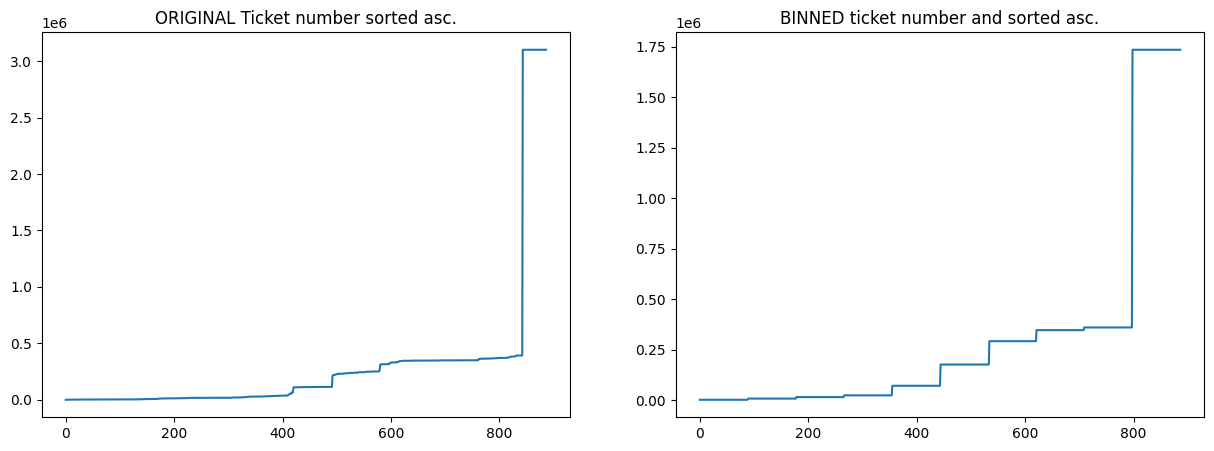

Arranging ticket numbers into 11 bins, assigning an interval mean for each bin value


In [310]:
#Arranging ticket numbers into 10 bins, assigning an interval mean for each bin value

titanic_df[TicketFeatures.TICKET_NUMBER_BINNED] = pd \
    .qcut(titanic_df[TicketFeatures.TICKET_NUMBER], q=binning_quantiles) \
    .apply(lambda i : int((i.left + i.right) / 2))

sorted_ticket_numbers = titanic_df[TicketFeatures.TICKET_NUMBER].sort_values().values
sorted_binned_ticket_numbers = titanic_df[TicketFeatures.TICKET_NUMBER_BINNED].sort_values().values

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(15, 5)

ax1.plot(sorted_ticket_numbers)
ax1.title.set_text('ORIGINAL Ticket number sorted asc.')

ax2.plot(sorted_binned_ticket_numbers)
ax2.title.set_text('BINNED ticket number and sorted asc.')

plt.show()

print(f'Arranging ticket numbers into {len(binning_quantiles)} bins, assigning an interval mean for each bin value')

## Train and test dataset split

In [294]:
x_train, x_test, y_train, y_test = train_test_split(
    titanic_df[features], 
    titanic_df[target_name], 
    test_size=0.3, 
    random_state=123)

x_train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Embarked,TicketNumberBinned,CabinNumber,DeckCode
PassengerId,,,,,,,,,,
417,1,2,female,34.0,1,1,S,23326,NaN,NaN
802,1,2,female,31.0,1,1,S,70670,NaN,NaN
513,1,1,male,36.0,0,0,S,14636,25,E
456,1,3,male,29.0,0,0,C,359723,NaN,NaN
758,0,2,male,18.0,0,0,S,70670,NaN,NaN


In [295]:
values = x_train['CabinNumber'].unique()
values
#x_train.isnull().mean().loc[lambda x : x > 0].sort_values(ascending=False)

array([nan, '25', '7', '21', '26', '49', '4', '35', '56', '30', '33',
       '124', '121', '65', '50', '51', '78', '91', '24', '', '52', '125',
       '63', '10', '58', '45', '104', '16', '6', '36', '37', '46', '57',
       '38', '126', '3', '2', '101', '82', '92', '106', '5', '22', '110',
       '96', '19', '68', '67', '8', '23', '90', '28', '34', '83', '70',
       '20', '85', '77', '102', '47', '15', '40', '123', '9', '32', '31',
       '14', '12', '17', '93', '39', '86', '44', '148', '11', '79', '42'],
      dtype=object)